In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os, json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

%matplotlib inline

### Image resolution
- Maximum 500
- Minimum 128
- Only approximately 120 images from 8000 in total that have resolution less than 256
- ***Setting resolution to 256x256 maybe a good choice.***

<br />

### Transfer learning choices
EfficientNet becoming the best choice because they have high accuracy with fewer parameters
- EfficientNetB0 (224, 224, 3) *** --> We will use this one.
- EfficientNetB1 (240, 240, 3)
- EfficientNetB2 (260, 260, 3)
- EfficientNetB3 (300, 300, 3)
- EfficientNetB4 (380, 380, 3)

In [2]:
# img_path = path to folder of image
# json_path = path to karpathy's json file ## dataset choices

img_path = 'dataset/Flicker8k_Dataset/'
json_path = 'caption_datasets/dataset_flickr8k.json'

In [3]:
from source.utils import prepare_data, Create_image_caption_pair
from source.Dataset import ImgCaption_Dataset

In [4]:
# Split dataset
train_img, train_cap, val_img, val_cap, test_img, test_cap, vocab_dict = prepare_data(img_path, json_path, 5)

In [5]:
# This function Create image_path and caption Encoding pair for any split
# Note that this function map caption word to token ("a dog is playing" --> [1, 4, 5, 8, 132, 2])
train_X, train_Y, train_caplen, train_idx = Create_image_caption_pair(train_img, train_cap, vocab_dict, 25)
val_X, val_Y, val_caplen, val_idx = Create_image_caption_pair(val_img, val_cap, vocab_dict, 25)
test_X, test_Y, test_caplen, test_idx = Create_image_caption_pair(test_img, test_cap, vocab_dict, 25)

In [6]:
# Define Image transformation
# Since we using pretrained from ImageNet, Normalization mean and std are also from ImageNet.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

# Get pair from Custom Datset
train_data = ImgCaption_Dataset(train_X, train_Y, train_caplen, train_idx, transform)
valid_data = ImgCaption_Dataset(val_X, val_Y, val_caplen, val_idx, transform)
test_data = ImgCaption_Dataset(test_X, test_Y, test_caplen, test_idx, transform)

# pytorch Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, pin_memory=True)

In [7]:
# Just Testing function
data = next(iter(train_loader))  

In [20]:
def denormalize(img ,mean, std):
    img[0, :, :] = (img[0, :, :] * std[0]) + mean[0]
    img[1, :, :] = (img[1, :, :] * std[1]) + mean[1]
    img[2, :, :] = (img[2, :, :] * std[2]) + mean[2]
    return img

def get_caption_back(token, vocab):
    caption = ""
    for tok in token:
        if tok == 1:
            continue
        if tok == 2:
            break
        word = list(vocab_dict.keys())[list(vocab_dict.values()).index(tok)]
        caption += str(word) + " "
    return caption

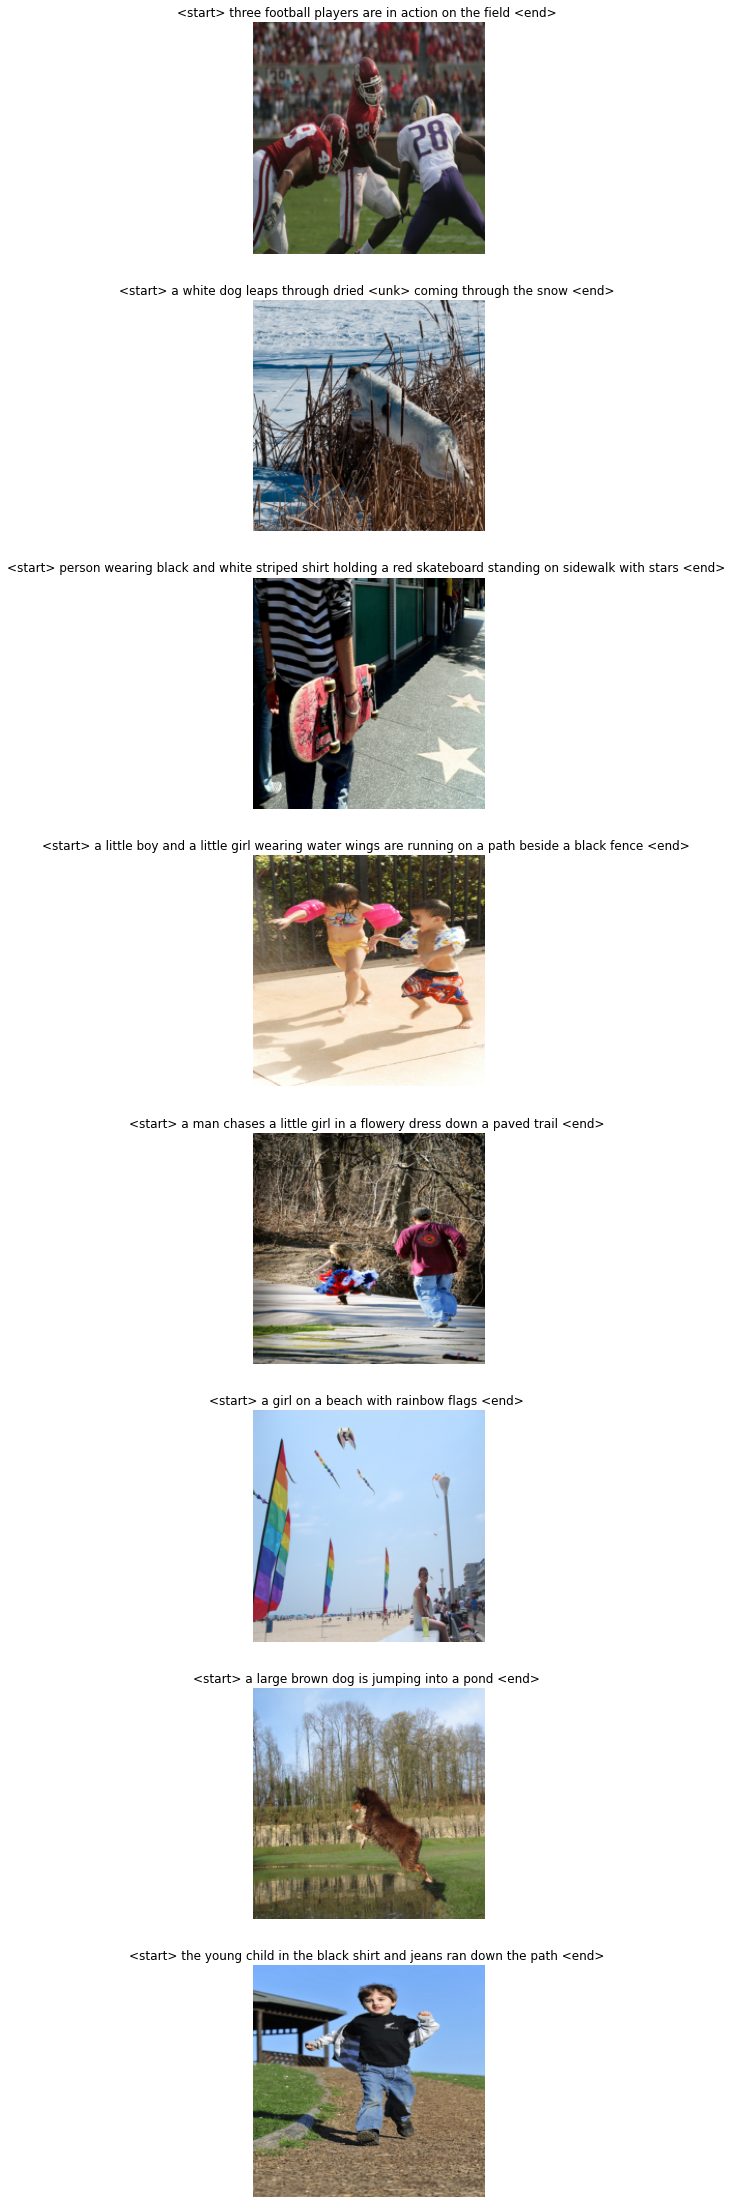

In [9]:
fig, ax = plt.subplots(8, 1, figsize=(40,40))
for i in range(8):
    img = denormalize(np.array(data[0][i]), mean, std)
    ax[i].set_title(get_caption_back(data[1][i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()

# Models exploration
<br>

#### BASELINE:
- Very simple Encoder-Decoder
- Encoder --> CNN (Pretrained backbone)
- Decoder --> RNN, GRU, LSTM (choices)


In [10]:
import torchvision.models as models
from torch import nn
from tqdm import tqdm

from source.models.Baseline import Encoder, Decoder # import model
#from source.helper import train, evaluate # import helper function

In [11]:
# initialize parameters 
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 32 # this is a limitation for inference time
EPOCH = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    "latent_size": 256,
    "hidden_layer": 512,
    "vocab_size": len(vocab_dict),
    "lr": 0.01
}

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=True, pin_memory=True, num_workers=3, prefetch_factor=3)
val_loader = DataLoader(dataset=valid_data, batch_size=TEST_BATCH_SIZE,
                        shuffle=True, pin_memory=True, num_workers=3, prefetch_factor=3)
test_loader = DataLoader(dataset=test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, pin_memory=True)

In [13]:
# Backbone
# Pretrained model is our choices.
effnet = models.efficientnet_b0(pretrained=True)

In [14]:
# Define model
encoder = Encoder(effnet, effnet.classifier[1].in_features, config["latent_size"]).to(device)
decoder = Decoder(config["latent_size"], config["hidden_layer"], config["vocab_size"]).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + \
        list(encoder.latent1.parameters()) + \
        list(encoder.latent2.parameters()) + \
        list(encoder.batchnorm1.parameters()) + \
        list(encoder.batchnorm2.parameters())

optimizer = torch.optim.AdamW(params, lr=config["lr"])

this_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               'max',
                                                               patience=3,
                                                               factor=0.1,
                                                               min_lr=1e-8) 

## Training helper

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from source.utils import get_caption_back

def train(encoder, decoder, device, train_loader, optimizer, criterion, log_interval=50):
    total_loss = 0
    encoder.train()
    decoder.train()
    for idx, data in enumerate(train_loader):
        data_img = data[0].to(device)
        data_cap = data[1].to(device)
        caption_length = data[2]
        encoder.zero_grad()
        decoder.zero_grad()
        img_latent = encoder(data_img)
        outputs, decoded_lengths = decoder(img_latent, data_cap, caption_length)
        packed_output = pack_padded_sequence(outputs, decoded_lengths, batch_first=True, enforce_sorted=False)
        packed_label = pack_padded_sequence(data_cap, decoded_lengths, batch_first=True, enforce_sorted=False)  
        loss = criterion(packed_output[0], packed_label[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if idx%log_interval == 0:
            print(f"Train step [{idx} / {len(train_loader)}], loss : ", loss.cpu().detach().numpy().item())
    total_loss /= len(train_loader)

    return total_loss
        

# Test
def evaluate(encoder, decoder, device, test_loader, vocab_dict, caption):
    encoder.eval()
    decoder.eval()
    total_bleu = []
    
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            data_img = data[0].to(device)
            data_cap = data[1].to(device)
            caption_length = data[2]
            caption_idx = data[3]
            img_latent = encoder(data_img)
            outputs = decoder.inference(img_latent)
            outputs = outputs.tolist()
            hypotheses = get_caption_back(outputs, vocab_dict)
            references = [caption[i] for i in caption_idx]
            
            bleu4 = corpus_bleu(references, hypotheses)
            total_bleu.append(bleu4)
    
    return np.array(total_bleu).mean()

In [17]:
best_val = 0
os.makedirs('weights', exist_ok=True)
best_enc_path = 'weights/baseline_enc_path.pth' 
best_dec_path = 'weights/baseline_dec_path.pth' 
for epoch in range(EPOCH):
    print("On Epoch: ", epoch+1, " . . .")
    loss = train(encoder, decoder, device, train_loader, optimizer, criterion)
    val_bleu4 = evaluate(encoder, decoder, device, val_loader, vocab_dict, val_cap)
    print(f"Average train loss: {loss} ", "# Validation BLEU : ", val_bleu4, "\n")
    if val_bleu4 > best_val:
        best_val = val_bleu4
        print("### New best model found, Saving model . . .")
        torch.save(encoder.state_dict(), best_enc_path)
        torch.save(decoder.state_dict(), best_dec_path)
    this_scheduler.step(np.around(val_bleu4, decimals=4)
print("Best BLUE score : ", best_val)

On Epoch:  0  . . .
Train step [0 / 468], loss :  7.880212306976318
Train step [50 / 468], loss :  3.541769027709961
Train step [100 / 468], loss :  3.2302000522613525
Train step [150 / 468], loss :  3.1769564151763916
Train step [200 / 468], loss :  3.1319169998168945
Train step [250 / 468], loss :  3.165192127227783
Train step [300 / 468], loss :  3.06604266166687
Train step [350 / 468], loss :  3.1320152282714844
Train step [400 / 468], loss :  2.976433038711548
Train step [450 / 468], loss :  2.9199836254119873


A:\Users\anaconda3\envs\pattern\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Average train loss: 3.251233719352983  # Validation BLEU :  0.09822769380119827 

### New best model found, Saving model . . .
On Epoch:  1  . . .
Train step [0 / 468], loss :  2.7963624000549316
Train step [50 / 468], loss :  2.4707651138305664
Train step [100 / 468], loss :  2.8488659858703613
Train step [150 / 468], loss :  2.5885462760925293
Train step [200 / 468], loss :  2.6015243530273438
Train step [250 / 468], loss :  2.637683153152466
Train step [300 / 468], loss :  2.620992422103882
Train step [350 / 468], loss :  2.8032562732696533
Train step [400 / 468], loss :  2.8299527168273926
Train step [450 / 468], loss :  2.6309142112731934
Average train loss: 2.744571298106104  # Validation BLEU :  0.11194418010301227 

### New best model found, Saving model . . .
On Epoch:  2  . . .
Train step [0 / 468], loss :  2.4135358333587646
Train step [50 / 468], loss :  2.290282964706421
Train step [100 / 468], loss :  2.5669031143188477
Train step [150 / 468], loss :  2.530590772628784
Tr

In [23]:
# Load best model for inference
best_enc_path = 'weights/baseline_enc_path.pth' 
best_dec_path = 'weights/baseline_dec_path.pth' 
encoder.load_state_dict(torch.load(best_enc_path))
decoder.load_state_dict(torch.load(best_dec_path))

<All keys matched successfully>

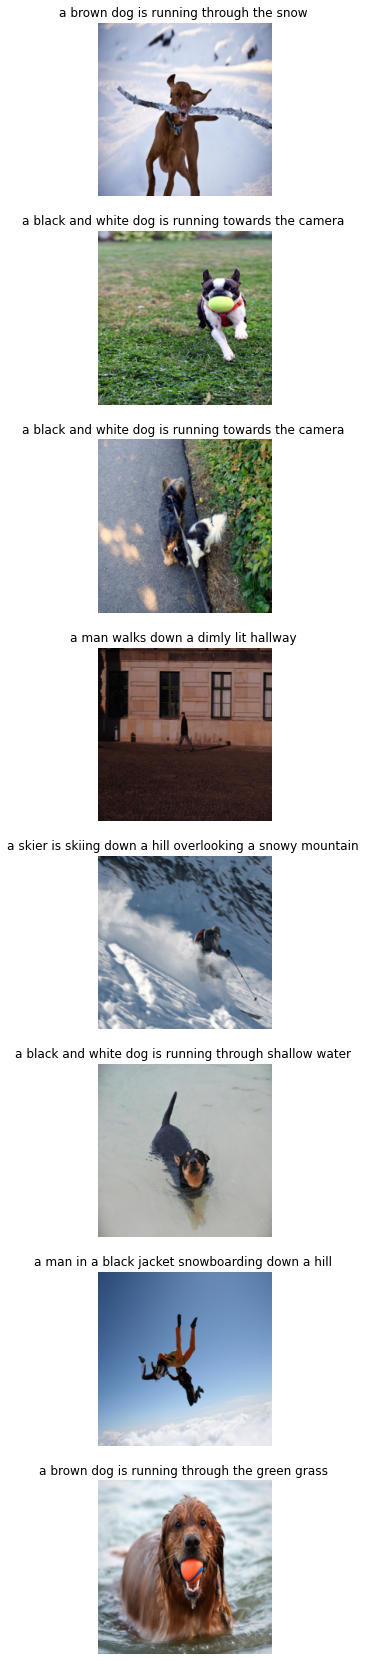

In [24]:
# Get Prediction from validation set
test_data = next(iter(test_loader))
encoder.eval()
decoder.eval()
with torch.no_grad():
    x = encoder(test_data[0].cuda())
    # At inference time, input should be only img latent.
    out = decoder.inference(x)
    #alphas = alphas.view(-1, 16, 16)
    
fig, ax = plt.subplots(8, 1, figsize=(30,30))
for i in range(8):
    img = denormalize(np.array(test_data[0][i].squeeze()), mean, std)
    ax[i].set_title(get_caption_back(out[i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()